## Create and test ion channel model

In [1]:
from experiments.ikr_markov import (toyoda_iv,
                                    toyoda_taua,
                                    toyoda_deact,
                                    toyoda_trec,
                                    toyoda_inact)

In [2]:
from ionchannelABC.experiment import setup

In [3]:
modelfile = 'models/ikr_markov.mmt'
#modelfile = 'models/Korhonen2009_iKr.mmt'

In [4]:
observations, model, summary_statistics = setup(modelfile,
                                                toyoda_iv,
                                                toyoda_taua,
                                                toyoda_deact,
                                                toyoda_trec,
                                                toyoda_inact)

In [5]:
assert len(observations)==len(summary_statistics(model({})))

## Set limits and generate uniform initial priors

In [6]:
from pyabc import Distribution, RV
limits = {'log_ikr.p_1': (-7., 3.),
          'ikr.p_2': (1e-7, 0.4),
          'log_ikr.p_3': (-7., 3.),
          'ikr.p_4': (1e-7, 0.4),
          'log_ikr.p_5': (-7., 3.),
          'ikr.p_6': (1e-7, 0.4),
          'log_ikr.p_9': (-7., 3.),
          'ikr.p_10': (1e-7, 0.4),
          'log_ikr.p_11': (-7., 3.),
          'ikr.p_12': (1e-7, 0.4),
          'ikr.s_A': (0., 5.),
          'ikr.h_A': (-100., 100.)
         }
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

## Run ABC calibration

In [7]:
import os, tempfile
db_path = ("sqlite:///" +
           os.path.join(tempfile.gettempdir(), "hl1_ikr.db"))

In [8]:
import logging
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)

In [9]:
from pyabc.populationstrategy import ConstantPopulationSize
from ionchannelABC import theoretical_population_size
pop_size = theoretical_population_size(2, len(limits))
print("Theoretical minimum population size is {} particles".format(pop_size))

Theoretical minimum population size is 4096 particles


In [10]:
from pyabc import ABCSMC
from pyabc.epsilon import MedianEpsilon
from pyabc.sampler import MulticoreEvalParallelSampler, SingleCoreSampler
from ionchannelABC import IonChannelDistance, EfficientMultivariateNormalTransition, IonChannelAcceptor

abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 exp_id=list(observations.exp_id),
                 variance=list(observations.variance),
                 delta=0.05),
             population_size=ConstantPopulationSize(5000),
             summary_statistics=summary_statistics,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(initial_epsilon=100),
             sampler=MulticoreEvalParallelSampler(n_procs=6),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {'0': 1.7602803923107038, '1': 1.7602803923107038, '2': 1.7602803923107038, '3': 1.3219273435990377, '4': 0.7776043197641317, '5': 0.3478861034461616, '6': 0.24480135992574564, '7': 0.16948035348155494, '8': 0.1362811694431988, '9': 0.1223993817640082, '10': 0.15552086395282688, '11': 0.2697810905304142, '12': 0.28126799194783114, '13': 0.12765642630288285, '14': 0.5379806537050044, '15': 0.6847026501700084, '16': 0.7928135949336962, '17': 1.0759613074100087, '18': 1.5063458303740147, '19': 1.5063458303740147, '20': 1.5063458303740147, '21': 0.18591518996358175, '22': 0.18591518996357978, '23': 0.18591518996358175, '24': 0.171670454921979, '25': 0.20281657086936153, '26': 0.18591518996358175, '27': 0.20289539580946064, '28': 0.18591518996358175, '29': 0.13943639247268705, '30': 0.1115491139781486, '31': 1.6431414405334837, '32': 1.643779801621529, '33': 1.0047706505280802, '34': 0.9514479895151233, '35': 0.821730279544328, '36': 0.6457706363513078, '37': 

In [11]:
obs = observations.to_dict()['y']
obs = {str(k): v for k, v in obs.items()}

In [12]:
abc_id = abc.new(db_path, obs)

In [ ]:
history = abc.run(minimum_epsilon=0.1, max_nr_populations=200, min_acceptance_rate=0.005)

INFO:ABC:t:0 eps:100
DEBUG:ABC:now submitting population 0


# Results analysis

In [21]:
from pyabc import History

In [23]:
history = History(db_path)
history.all_runs()

[<ABCSMC(id=1, start_time=2019-07-16 15:16:46.691662, end_time=None)>,
 <ABCSMC(id=2, start_time=2019-07-16 15:20:21.065814, end_time=2019-07-16 15:21:23.319129)>]

In [24]:
history.id = 2

In [25]:
df, w = history.get_distribution(m=0)

In [26]:
df.describe()

name,ina.p_2,ina.p_4,ina.p_6,ina.p_8,log_ina.p_1,log_ina.p_3,log_ina.p_5,log_ina.p_7
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.152418,0.124618,0.204145,0.212663,1.497692,-1.892742,-1.361832,-2.912250
std,0.109698,0.089901,0.090097,0.088270,1.240786,1.883950,2.443193,2.446290
min,0.005179,0.011122,0.063843,0.090318,-1.421610,-5.524446,-6.200844,-6.660549
25%,0.076660,0.057064,0.113290,0.154365,0.610072,-3.246264,-2.897067,-4.863269
50%,0.133123,0.103693,0.191261,0.174066,1.876010,-1.755545,-0.905199,-3.106732
75%,0.191822,0.189799,0.283577,0.292748,2.358829,-0.426004,0.316332,-1.976666
max,0.395849,0.267499,0.366606,0.373880,2.985568,2.103943,2.592736,2.292265


/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/site-packages/matplotlib/tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/site-packages/matplotlib/tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/site-packages/matplotlib/tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/site-packages/matplotlib/tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make ax

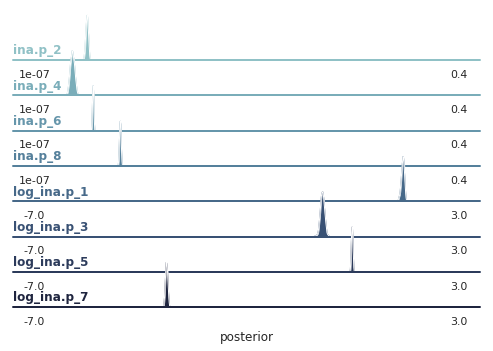

In [21]:
from ionchannelABC import plot_parameters_kde
g = plot_parameters_kde(df, w, limits, aspect=12,height=0.6)

# Samples for quantitative analysis

In [22]:
# Generate parameter samples
n_samples = 100
df, w = history.get_distribution(m=0)
th_samples = df.sample(n=n_samples, weights=w, replace=True).to_dict(orient='records')

In [9]:
plotting_obs = observations.copy()

In [10]:
plotting_obs.rename({'exp_id': 'exp', 'variance': 'errs'}, axis=1, inplace=True)

In [11]:
import numpy as np
plotting_obs['errs'] = np.sqrt(plotting_obs['errs'])

In [23]:
# Generate sim results samples
import pandas as pd
samples = pd.DataFrame({})
for i, th in enumerate(th_samples):
    results = summary_statistics(log_model(th))
    output = pd.DataFrame({'x': observations.x, 'y': list(results.values()),
                           'exp_id': observations.exp_id})
    #output = model.sample(pars=th, n_x=50)
    output['sample'] = i
    output['distribution'] = 'post'
    samples = samples.append(output, ignore_index=True)

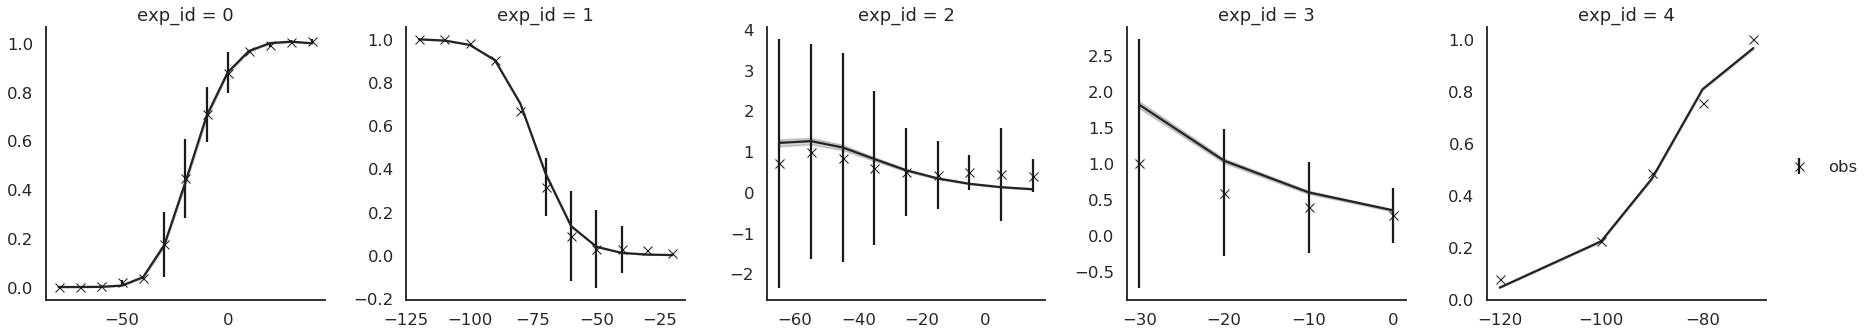

In [24]:
from ionchannelABC import plot_sim_results
import seaborn as sns
sns.set_context('talk')
g = plot_sim_results(samples, obs=observations)

# Set axis labels
#xlabels = ["voltage, mV", "voltage, mV", "voltage, mV", "time, ms", "time, ms","voltage, mV"]
#ylabels = ["current density, pA/pF", "activation", "inactivation", "recovery", "normalised current","current density, pA/pF"]
#for ax, xl in zip(g.axes.flatten(), xlabels):
#    ax.set_xlabel(xl)
#for ax, yl in zip(g.axes.flatten(), ylabels):
#    ax.set_ylabel(yl)

In [31]:
#g.savefig('results/icat-generic/icat_sim_results.pdf')

In [51]:
def plot_sim_results_all(samples: pd.DataFrame):
    with sns.color_palette("gray"):
        grid = sns.relplot(x='x', y='y',
                           col='exp',
                           units='sample',
                           kind='line',
                           data=samples,
                           estimator=None, lw=0.5,
                           alpha=0.5,
                           #estimator=np.median,
                           facet_kws={'sharex': 'col',
                                      'sharey': 'col'})
    return grid

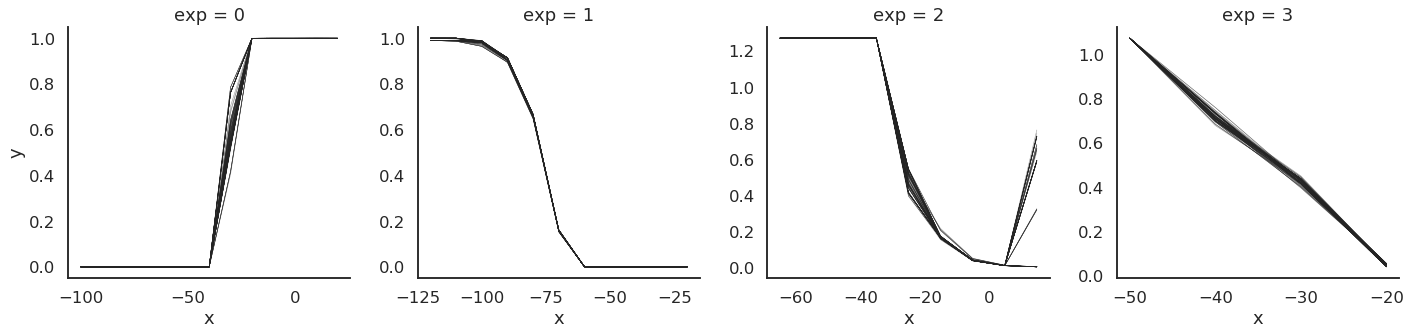

In [52]:
grid2 = plot_sim_results_all(samples)

In [33]:
#grid2.savefig('results/icat-generic/icat_sim_results_all.pdf')

In [35]:
import numpy as np

In [42]:
# Mean current density
print(np.mean(samples[samples.exp=='0'].groupby('sample').min()['y']))
# Std current density
print(np.std(samples[samples.exp=='0'].groupby('sample').min()['y']))

-0.9792263129382246
0.060452038127623814


In [43]:
import scipy.stats as st
peak_current = samples[samples['exp']=='0'].groupby('sample').min()['y'].tolist()
rv = st.rv_discrete(values=(peak_current, [1/len(peak_current),]*len(peak_current)))

In [44]:
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: -0.9929750589235674
95% CI: (-1.0714884415582595, -0.8489199437971181)


In [45]:
# Voltage of peak current density
idxs = samples[samples.exp=='0'].groupby('sample').idxmin()['y']
print("mean: {}".format(np.mean(samples.iloc[idxs]['x'])))
print("STD: {}".format(np.std(samples.iloc[idxs]['x'])))

mean: -20.1
STD: 0.7


In [46]:
voltage_peak = samples.iloc[idxs]['x'].tolist()
rv = st.rv_discrete(values=(voltage_peak, [1/len(voltage_peak),]*len(voltage_peak)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: -20.0
95% CI: (-20.0, -20.0)


In [48]:
# Half activation potential
# Fit of activation to Boltzmann equation
from scipy.optimize import curve_fit
grouped = samples[samples['exp']=='1'].groupby('sample')
def fit_boltzmann(group):
    def boltzmann(V, Vhalf, K):
        return 1/(1+np.exp((Vhalf-V)/K))
    guess = (-30, 10)
    popt, _ = curve_fit(boltzmann, group.x, group.y)
    return popt
output = grouped.apply(fit_boltzmann).apply(pd.Series)

In [49]:
print(np.mean(output))
print(np.std(output))

0   -33.399071
1     5.739255
dtype: float64
0    0.823473
1    0.366996
dtype: float64


In [50]:
Vhalf = output[0].tolist()
rv = st.rv_discrete(values=(Vhalf, [1/len(Vhalf),]*len(Vhalf)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: -33.407394098238164
95% CI: (-34.93130871417603, -31.973122716861205)


In [51]:
slope = output[1].tolist()
rv = st.rv_discrete(values=(slope, [1/len(slope),]*len(slope)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: 5.728938366573993
95% CI: (5.117385157850234, 6.485585591389819)


In [52]:
# Half activation potential
grouped = samples[samples['exp']=='2'].groupby('sample')
def fit_boltzmann(group):
    def boltzmann(V, Vhalf, K):
        return 1-1/(1+np.exp((Vhalf-V)/K))
    guess = (-100, 10)
    popt, _ = curve_fit(boltzmann, group.x, group.y,
                        bounds=([-100, 1], [0, 30]))
    return popt
output = grouped.apply(fit_boltzmann).apply(pd.Series)

In [53]:
print(np.mean(output))
print(np.std(output))

0   -49.011222
1     4.399126
dtype: float64
0    0.613833
1    0.306758
dtype: float64


In [54]:
Vhalf = output[0].tolist()
rv = st.rv_discrete(values=(Vhalf, [1/len(Vhalf),]*len(Vhalf)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: -49.01404281457659
95% CI: (-50.06478757419054, -47.57952101705519)


In [55]:
slope = output[1].tolist()
rv = st.rv_discrete(values=(slope, [1/len(slope),]*len(slope)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: 4.420440009120772
95% CI: (3.7821747606540193, 4.959106709731536)


In [56]:
# Recovery time constant
grouped = samples[samples.exp=='3'].groupby('sample')
def fit_single_exp(group):
    def single_exp(t, I_max, tau):
        return I_max*(1-np.exp(-t/tau))
    guess = (1, 50)
    popt, _ = curve_fit(single_exp, group.x, group.y, guess)
    return popt[1]
output = grouped.apply(fit_single_exp)

In [57]:
print(np.mean(output))
print(np.std(output))

114.50830523453935
5.781251582667316


In [58]:
tau = output.tolist()
rv = st.rv_discrete(values=(tau, [1/len(tau),]*len(tau)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: 113.75533911706513
95% CI: (104.11137902797657, 125.98102619971708)
